In [8]:
import numpy as np
import pandas as pd
from pandas import DataFrame, read_csv, unique
from matplotlib.pyplot import figure, savefig, show
import matplotlib as plt
from sklearn.naive_bayes import GaussianNB
from libs.ds_charts import plot_evaluation_results, bar_chart
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB, CategoricalNB
from sklearn.metrics import accuracy_score
from pandas import concat, DataFrame


### NAIVE BAYES

In [9]:
### FILES
file_tag_zscore = 'nyc_collisions_scaled_zscore'
filename_zscore = 'data/nyc_collisions_scaled_zscore'

file_tag_minmax = 'nyc_collisions_scaled_minmax'
filename_minmax = 'data/nyc_collisions_scaled_minmax'

target = 'PERSON_INJURY'

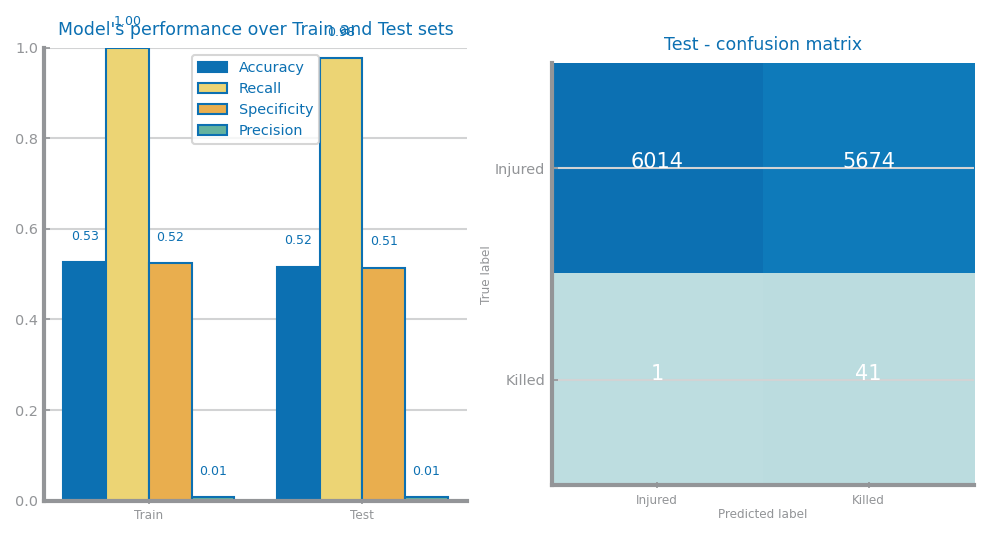

In [10]:
#PREPARE TRAIN AND TEST SZCORE
train_zscore: DataFrame = read_csv(f'{filename_zscore}_train.csv')
test_zscore: DataFrame = read_csv(f'{filename_zscore}_test.csv')

train_zscore.drop(['CRASH_DATE','CRASH_TIME','PERSON_ID'], axis=1, inplace=True)
test_zscore.drop(['CRASH_DATE','CRASH_TIME','PERSON_ID'],axis=1, inplace=True)

trnY_zscore: np.ndarray = train_zscore.pop(target).values
trnX_zscore: np.ndarray = train_zscore.values
labels = unique(trnY_zscore)
labels.sort()

tstY_zscore: np.ndarray = test_zscore.pop(target).values
tstX_zscore: np.ndarray = test_zscore.values

clf = GaussianNB()
clf.fit(trnX_zscore, trnY_zscore)
prd_trn = clf.predict(trnX_zscore)
prd_tst = clf.predict(tstX_zscore)
plot_evaluation_results(labels, trnY_zscore, prd_trn, tstY_zscore, prd_tst)
savefig('images/{file_tag}_nb_best_zscore.png')
show()

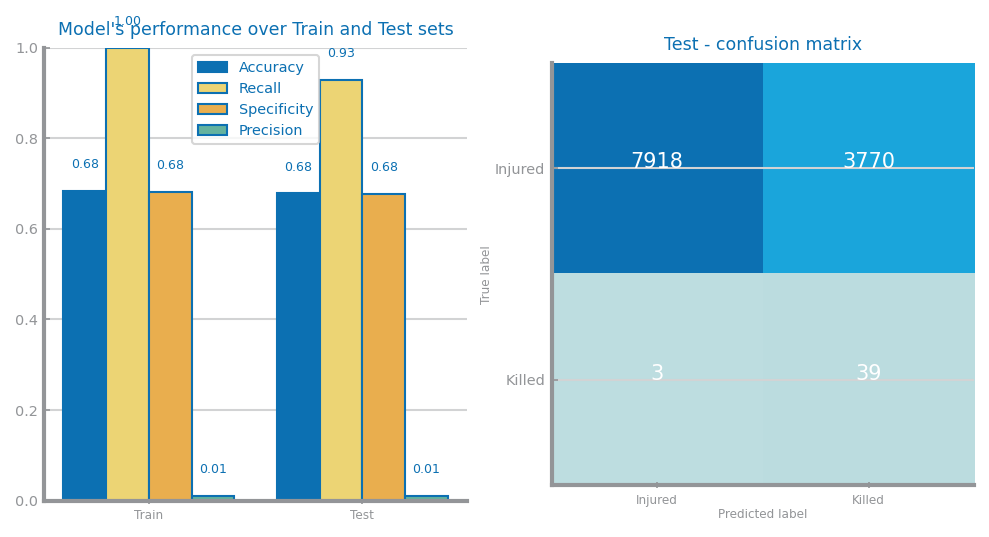

In [11]:
#PREPARE TRAIN AND TEST MINMAX
train_minmax: DataFrame = read_csv(f'{filename_minmax}_train.csv')
test_minmax: DataFrame = read_csv(f'{filename_minmax}_test.csv')

train_minmax.drop(['CRASH_DATE','CRASH_TIME','PERSON_ID'], axis=1, inplace=True)
test_minmax.drop(['CRASH_DATE','CRASH_TIME','PERSON_ID'],axis=1, inplace=True)

trnY_minmax: np.ndarray = train_minmax.pop(target).values
trnX_minmax: np.ndarray = train_minmax.values
labels = unique(trnY_minmax)
labels.sort()

tstY_minmax: np.ndarray = test_minmax.pop(target).values
tstX_minmax: np.ndarray = test_minmax.values

clf = GaussianNB()
clf.fit(trnX_minmax, trnY_minmax)
prd_trn = clf.predict(trnX_minmax)
prd_tst = clf.predict(tstX_minmax)
plot_evaluation_results(labels, trnY_minmax, prd_trn, tstY_minmax, prd_tst)
savefig('images/{file_tag}_nb_best_minmax.png')
show()


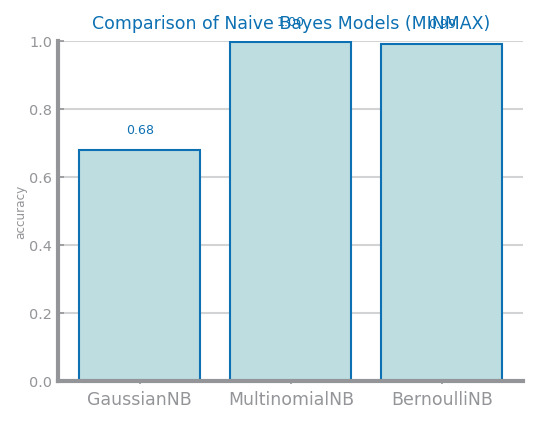

In [12]:
#MINMAX STUDY
estimators = {'GaussianNB': GaussianNB(),
              'MultinomialNB': MultinomialNB(),
              'BernoulliNB': BernoulliNB()
              #'CategoricalNB': CategoricalNB
              }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX_minmax, trnY_minmax)
    prdY = estimators[clf].predict(tstX_minmax)
    yvalues.append(accuracy_score(tstY_minmax, prdY))

figure()
bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models (MINMAX)', ylabel='accuracy', percentage=True)
savefig(f'images/{file_tag_minmax}_nb_study_minmax.png')
show()

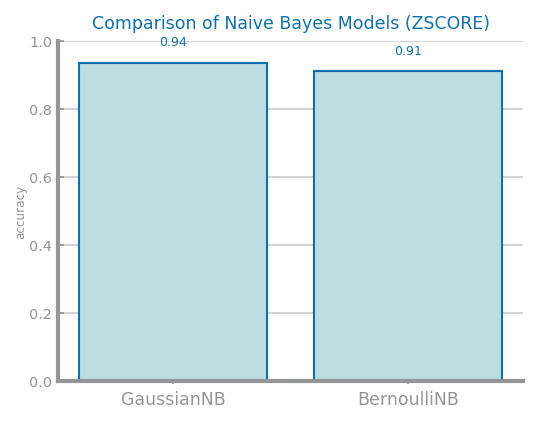

In [13]:
#ZSCORE STUDY
estimators = {'GaussianNB': GaussianNB(),
              'BernoulliNB': BernoulliNB()
              #'CategoricalNB': CategoricalNB
              }

xvalues = []
yvalues = []
for clf in estimators:
    xvalues.append(clf)
    estimators[clf].fit(trnX_minmax, trnY_zscore)
    prdY = estimators[clf].predict(tstX_zscore)
    yvalues.append(accuracy_score(tstY_zscore, prdY))

figure()
bar_chart(xvalues, yvalues, title='Comparison of Naive Bayes Models (ZSCORE)', ylabel='accuracy', percentage=True)
savefig(f'images/{file_tag_zscore}_nb_study_minmax.png')
show()

### BALANCING

Minority class= Killed : 139
Majority class= Injured : 38959
Proportion: 0.0 : 1


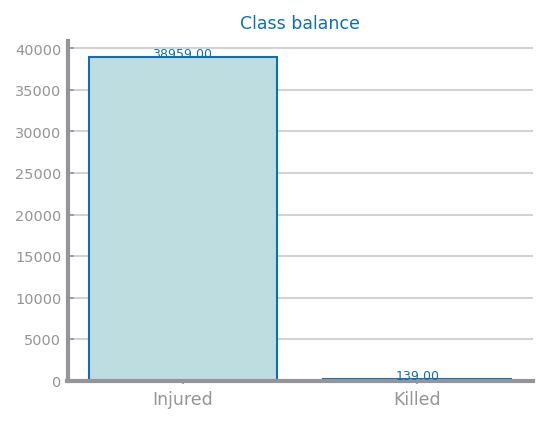

In [16]:
filename = 'data/nyc_collisions_scaled_zscore.csv'
file = "nyc_collisions_scaled_zscore"
original = read_csv(filename, sep=',', decimal='.')
class_var = 'PERSON_INJURY'
target_count = original[class_var].value_counts()
positive_class = target_count.idxmin()
negative_class = target_count.idxmax()
#ind_positive_class = target_count.index.get_loc(positive_class)
print('Minority class=', positive_class, ':', target_count[positive_class])
print('Majority class=', negative_class, ':', target_count[negative_class])
print('Proportion:', round(target_count[positive_class] / target_count[negative_class], 2), ': 1')
values = {'Original': [target_count[positive_class], target_count[negative_class]]}

figure()
bar_chart(target_count.index, target_count.values, title='Class balance')
savefig(f'images/{file}_balance.png')
show()

In [17]:
df_positives = original[original[class_var] == positive_class]
df_negatives = original[original[class_var] == negative_class]

In [18]:
df_neg_sample = DataFrame(df_negatives.sample(len(df_positives)))
df_under = concat([df_positives, df_neg_sample], axis=0)
df_under.to_csv(f'data/{file}_under.csv', index=False)
values['UnderSample'] = [len(df_positives), len(df_neg_sample)]
print('Minority class=', positive_class, ':', len(df_positives))
print('Majority class=', negative_class, ':', len(df_neg_sample))
print('Proportion:', round(len(df_positives) / len(df_neg_sample), 2), ': 1')

Minority class= Killed : 139
Majority class= Injured : 139
Proportion: 1.0 : 1


In [19]:
df_pos_sample = DataFrame(df_positives.sample(len(df_negatives), replace=True))
df_over = concat([df_pos_sample, df_negatives], axis=0)
df_over.to_csv(f'data/{file}_over.csv', index=False)
values['OverSample'] = [len(df_pos_sample), len(df_negatives)]
print('Minority class=', positive_class, ':', len(df_pos_sample))
print('Majority class=', negative_class, ':', len(df_negatives))
print('Proportion:', round(len(df_pos_sample) / len(df_negatives), 2), ': 1')

Minority class= Killed : 38959
Majority class= Injured : 38959
Proportion: 1.0 : 1


In [21]:
from pandas import Series
from imblearn.over_sampling import SMOTE
RANDOM_STATE = 42

smote = SMOTE(sampling_strategy='minority', random_state=RANDOM_STATE)
y = original.pop(class_var).values
X = original.values
smote_X, smote_y = smote.fit_resample(X, y)
df_smote = concat([DataFrame(smote_X), DataFrame(smote_y)], axis=1)
df_smote.columns = list(original.columns) + [class_var]
df_smote.to_csv(f'data/{file}_smote.csv', index=False)

smote_target_count = Series(smote_y).value_counts()
values['SMOTE'] = [smote_target_count[positive_class], smote_target_count[negative_class]]
print('Minority class=', positive_class, ':', smote_target_count[positive_class])
print('Majority class=', negative_class, ':', smote_target_count[negative_class])
print('Proportion:', round(smote_target_count[positive_class] / smote_target_count[negative_class], 2), ': 1')


KeyError: 'PERSON_INJURY'